In [97]:
import pandas as pd
import numpy as np
df = pd.read_csv('../data/googleplaystore.csv')

# Make column 'Size' has the same unit of measurement: MB
df['size_num'] = df.Size.str.extract('(\d+)') #.astype(int)
df['size_letter'] = df.Size.str.extract('([a-zA-Z]\w{0,})')
df['size_num'] = df[['size_num']].fillna(0)
df['size_num'] = df['size_num'].astype(int)
df.loc[df['size_letter'] == 'k',['size_num']] = df[df['size_letter']=='k']['size_num']/1000
df.loc[df['Size']!='Varies with device',['Size']] = df['size_num']
df.drop(['size_num','size_letter'],axis=1,inplace=True)

# Split entries in column Genres
df['Genres'] = df.Genres.str.split(';')
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19,"10,000+",Free,0,Everyone,[Art & Design],7-Jan-18,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14,"500,000+",Free,0,Everyone,"[Art & Design, Pretend Play]",15-Jan-18,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8,"5,000,000+",Free,0,Everyone,[Art & Design],1-Aug-18,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25,"50,000,000+",Free,0,Teen,[Art & Design],8-Jun-18,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2,"100,000+",Free,0,Everyone,"[Art & Design, Creativity]",20-Jun-18,1.1,4.4 and up


In [69]:
genres = ["Action","Action & Adventure","Adventure","Art & Design","Arcade","Auto & Vehicles","Beauty","Board","Books & Reference","Brain Games","Business","Card","Casino","Casual","Comics","Communication","Creativity","Dating","Education","Educational","Entertainment","Events","Finance","Food & Drink","Health & Fitness","House & Home","Libraries & Demo","Lifestyle","Maps & Navigation","Medical","Music","Music & Audio","Music & Video","News & Magazines","Parenting","Personalization","Photography","Pretend Play","Productivity","Puzzle","Racing","Role Playing","Shopping","Simulation","Social","Sports","Strategy","Tools","Travel & Local","Trivia","Video Players & Editors","Weather","Word"]
df_preprocessed = df
def generate_lst(genre):
    lst_temp = []
    for i in range(len(df_preprocessed)):
        if genre in df_preprocessed.Genres[i]:
            lst_temp.append(1)
        else:
            lst_temp.append(0)
    return lst_temp
d = {genre: generate_lst(genre) for genre in genres}
transfored_genres = pd.DataFrame(d)
df_preprocessed = pd.concat([df_preprocessed.drop('Genres',axis = 1),transfored_genres],axis=1)
df_preprocessed.drop_duplicates(keep = 'last', subset = genres + ['App','Rating','Size','Installs','Type','Price','Content Rating', 'Last Updated', 'Current Ver','Android Ver'],inplace=True)
df_preprocessed.reset_index(inplace=True,drop=True)

In [70]:
index_list = [2308,4641,3501,590,1795,381,3455,3232,2966,4379,6313,2410,870,184,1375,2968,1519,5749,817,4412,860,1977,3037,1526,5061,1309,3315,2053,5510,1909,2982,3189]
df_preprocessed = df_preprocessed.drop(index_list)
df_preprocessed.reset_index(inplace=True,drop=True)

In [71]:
# Preprocess column Size
size_varies = []
for value in df_preprocessed['Size']:
    if value == 'Varies with device':
        size_varies.append(1)
    else:
        size_varies.append(0)
df_preprocessed['Size_varies'] = size_varies
# Preprocess target variable
df_preprocessed['Size'] = df_preprocessed['Size'].replace(to_replace ='Varies with device', value = np.nan)
df_preprocessed.loc[7983,['Type']] = 'Free'
df_preprocessed.loc[7983,['Reviews']] = 119477
df_preprocessed['Installs'] = df_preprocessed['Installs'].replace(to_replace =['0+','0','1+','5+','10+','50+','100+','500+','1,000+','5,000+'], value = '<10k')
df_preprocessed['Installs'] = df_preprocessed['Installs'].replace(to_replace =['10,000+','50,000+','100,000+'], value = '<500k')
df_preprocessed['Installs'] = df_preprocessed['Installs'].replace(to_replace =['500,000+','1,000,000+'], value = '<5m')
df_preprocessed['Installs'] = df_preprocessed['Installs'].replace(to_replace =['5,000,000+','10,000,000+','50,000,000+','100,000,000+','500,000,000+','1,000,000,000+'], value = '>5m')
#df_preprocessed.head()

In [72]:
# Preprocess Current Ver and Android Ver
currentVer_varies = []
for value in df_preprocessed['Current Ver']:
    if value == 'Varies with device':
        currentVer_varies.append(1)
    else:
        currentVer_varies.append(0)
df_preprocessed['Current_Ver_Varies'] = currentVer_varies

AndroidVer_varies = []
for value in df_preprocessed['Android Ver']:
    if value == 'Varies with device':
        AndroidVer_varies.append(1)
    else:
        AndroidVer_varies.append(0)
df_preprocessed['Android_Ver_Varies'] = AndroidVer_varies

In [73]:
# Extract the most significant digit of Version number
df_preprocessed['Current Ver'] = df_preprocessed['Current Ver'].replace(to_replace ='Varies with device', value = np.nan)
df_preprocessed['Android Ver'] = df_preprocessed['Android Ver'].replace(to_replace ='Varies with device', value = np.nan)
df_preprocessed['Current_Ver_truncated'] = df_preprocessed['Current Ver'].str[0]
df_preprocessed['Android_Ver_truncated'] = df_preprocessed['Android Ver'].str[0]

In [74]:
df2 = pd.read_csv('../data/googleplaystore_user_reviews.csv')
df2_temp = df2[['App','Sentiment_Polarity','Sentiment_Subjectivity']].groupby(['App']).mean().reset_index()
df_preprocessed = pd.merge(df_preprocessed,df2_temp,on='App',how='left')

In [75]:
df_preprocessed['Current_Ver_truncated'] = pd.to_numeric(df_preprocessed['Current_Ver_truncated'],errors='coerce')
df_preprocessed['Android_Ver_truncated'] = pd.to_numeric(df_preprocessed['Android_Ver_truncated'],errors='coerce')
df_preprocessed.drop(['Current Ver','Android Ver'],axis = 1, inplace=True)

In [76]:
import re
lst_price = []
for price in df_preprocessed.Price:
    lst_price.append(float(re.findall(r'[\d\.\d]+', price)[0]))
df_preprocessed.Price = lst_price

from datetime import datetime
lst_date = []
for date in df_preprocessed['Last Updated']:
    lst_date.append(datetime.strptime(date, '%d-%b-%y'))
df_preprocessed['Last Updated'] = lst_date

In [77]:
# Deal with missing values
df_preprocessed.isnull().sum()/len(df_preprocessed)

App                        0.000000
Category                   0.000000
Rating                     0.151406
Reviews                    0.000000
Size                       0.127119
Installs                   0.000000
Type                       0.000000
Price                      0.000000
Content Rating             0.000000
Last Updated               0.000000
Action                     0.000000
Action & Adventure         0.000000
Adventure                  0.000000
Art & Design               0.000000
Arcade                     0.000000
Auto & Vehicles            0.000000
Beauty                     0.000000
Board                      0.000000
Books & Reference          0.000000
Brain Games                0.000000
Business                   0.000000
Card                       0.000000
Casino                     0.000000
Casual                     0.000000
Comics                     0.000000
Communication              0.000000
Creativity                 0.000000
Dating                     0

In [78]:
# Since 91.5% of values are missing, we drop these two columns. 
df_preprocessed.drop(['Sentiment_Polarity','Sentiment_Subjectivity'],axis=1,inplace=True)

In [79]:
import math as ma
import scipy.stats as st
import numpy as np
def checks_input_mcar_tests(data):
    """ Checks whether the input parameter of class McarTests is correct
            Parameters
            ----------
            data:
                The input of McarTests specified as 'data'
            Returns
            -------
            bool
                True if input is correct
            """

    if not isinstance(data, pd.DataFrame):
        print("Error: Data should be a Pandas DataFrame")
        return False

    if not any(data.dtypes.values == np.float):
        if not any(data.dtypes.values == np.int):
            print("Error: Dataset cannot contain other value types than floats and/or integers")
            return False

    if not data.isnull().values.any():
        print("Error: No NaN's in given data")
        return False

    return True


def mcar_test(data):
    """ Implementation of Little's MCAR test
    Parameters
    ----------
    data: Pandas DataFrame
        An incomplete dataset with samples as index and variables as columns
    Returns
    -------
    p_value: Float
        This value is the outcome of a chi-square statistical test, testing whether the null hypothesis
        'the missingness mechanism of the incomplete dataset is MCAR' can be rejected.
    """

    if not checks_input_mcar_tests(data):
        raise Exception("Input not correct")

    dataset = data.copy()
    vars = dataset.dtypes.index.values
    n_var = dataset.shape[1]

    # mean and covariance estimates
    # ideally, this is done with a maximum likelihood estimator
    gmean = dataset.mean()
    gcov = dataset.cov()

    # set up missing data patterns
    r = 1 * dataset.isnull()
    mdp = np.dot(r, list(map(lambda x: ma.pow(2, x), range(n_var))))
    sorted_mdp = sorted(np.unique(mdp))
    n_pat = len(sorted_mdp)
    correct_mdp = list(map(lambda x: sorted_mdp.index(x), mdp))
    dataset['mdp'] = pd.Series(correct_mdp, index=dataset.index)

    # calculate statistic and df
    pj = 0
    d2 = 0
    for i in range(n_pat):
        dataset_temp = dataset.loc[dataset['mdp'] == i, vars]
        select_vars = ~dataset_temp.isnull().any()
        pj += np.sum(select_vars)
        select_vars = vars[select_vars]
        means = dataset_temp[select_vars].mean() - gmean[select_vars]
        select_cov = gcov.loc[select_vars, select_vars]
        mj = len(dataset_temp)
        parta = np.dot(means.T, np.linalg.solve(select_cov, np.identity(select_cov.shape[1])))
        d2 += mj * (np.dot(parta, means))
    df = pj - n_var
    # perform test and save output
    p_value = 1 - st.chi2.cdf(d2, df)
    return p_value

print(mcar_test(df_preprocessed[['Rating','Size']]))

0.0


In [80]:
df_preprocessed[df_preprocessed.isnull().any(axis=1)].shape[0]

2816

In [81]:
df_preprocessed.shape

(9676, 68)

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
X = df_preprocessed.drop('Installs', axis=1)
y = df_preprocessed[['Installs']]
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2, random_state = 42)
xTrain.reset_index(inplace=True,drop=True)

In [16]:
# temp = xTrain[xTrain['App']=='CBS Sports App - Scores, News, Stats & Watch Live']
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(temp)
cont_frs_impute = ['Rating','Reviews','Size','Price']
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
X = xTrain[cont_frs_impute].values
imputer = IterativeImputer(estimator = RandomForestRegressor(),random_state=100) #RandomForestRegressor?
X_impute = imputer.fit_transform(X)
xTrain[cont_frs_impute] = X_impute

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [17]:
enc = OneHotEncoder(sparse=False)
category = enc.fit_transform(xTrain[['Category']])
category = pd.DataFrame(category, columns = enc.get_feature_names())
xTrain = pd.concat([xTrain,category],axis = 1)

In [18]:
#xTrain['Category'] = category
enc = OrdinalEncoder(categories = [['Everyone', 'Everyone 10+', 'Teen', 'Mature 17+', 'Adults only 18+','Unrated']])
content_rating = pd.DataFrame(enc.fit_transform(xTrain[['Content Rating']]),columns=['Content Rating'])
xTrain['Content Rating'] = content_rating

In [19]:
enc = OrdinalEncoder(categories = [['<10k','<500k','<5m','>5m']])
target_transformed = pd.DataFrame(enc.fit_transform(yTrain[['Installs']]),columns=['Installs'])
yTrain = target_transformed

In [20]:
enc = OrdinalEncoder(categories = [['Free','Paid']])
xTrain['Type'] = pd.DataFrame(enc.fit_transform(xTrain[['Type']]),columns=['Free_or_Paid'])
#xTrain.isnull().sum()
#df_preprocessed.isnull().sum()
#xTrain[xTrain['Android Ver'].isnull()]
#xTrain[['Android Ver']].iloc[854,:]
xTrain.head()

,App,Category,Rating,Reviews,Size,Type,Price,Content Rating,Last Updated,Action,...,x0_PERSONALIZATION,x0_PHOTOGRAPHY,x0_PRODUCTIVITY,x0_SHOPPING,x0_SOCIAL,x0_SPORTS,x0_TOOLS,x0_TRAVEL_AND_LOCAL,x0_VIDEO_PLAYERS,x0_WEATHER
0,Jewels Star: OZ adventure,GAME,4.5,21892.0,14.0,0.0,0.00,0.0,2017-12-29,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Device Help,TOOLS,4.2,28860.0,14.7,0.0,0.00,0.0,2018-07-18,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,Dragonplay™ Poker Texas Holdem,GAME,4.5,197979.0,52.2,0.0,0.00,2.0,2018-08-07,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Deus Ex GO,FAMILY,4.5,9699.0,23.0,1.0,0.99,2.0,2018-07-23,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AX Player -Nougat Video Player,VIDEO_PLAYERS,4.1,15765.0,10.0,0.0,0.00,0.0,2014-09-12,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [21]:
scaler = MinMaxScaler()
scaled_rating = scaler.fit_transform(pd.DataFrame(xTrain['Rating']))
xTrain['Rating'] = pd.DataFrame(scaled_rating,columns=['Rating'])

scaler = MinMaxScaler()
scaled_size = scaler.fit_transform(pd.DataFrame(xTrain['Size']))
xTrain['Size'] = pd.DataFrame(scaled_size,columns=['Size'])

scaler = MinMaxScaler()
scaled_price = scaler.fit_transform(pd.DataFrame(xTrain['Price']))
xTrain['Price'] = pd.DataFrame(scaled_price,columns=['Price'])

scaler = StandardScaler()
scaled_reviews = scaler.fit_transform(pd.DataFrame(xTrain['Reviews']))
xTrain['Reviews'] = pd.DataFrame(scaled_reviews,columns=['Number of Reviews'])

# dropped = xTrain.drop(['Category','Genres','Content Rating','Rating','Reviews'],axis=1)
# dropped = dropped.reset_index()
# xTrain_concat = pd.concat([dropped, category,content_rating,scaled_rating,scaled_reviews],axis = 1)

In [22]:
#xTrain_concat.to_excel('xTrain_set.xlsx', sheet_name='sheet1', index=False)
scaler = MinMaxScaler()
scaled_rating = scaler.fit_transform(pd.DataFrame(xTrain['Last Updated']))
xTrain['Last Updated'] = pd.DataFrame(scaled_rating,columns=['Last Updated'])

In [23]:
xTrain.drop(['Category'],axis=1,inplace=True)

In [24]:
xTrain.columns

Index(['App', 'Rating', 'Reviews', 'Size', 'Type', 'Price', 'Content Rating',
       'Last Updated', 'Action', 'Action & Adventure', 'Adventure',
       'Art & Design', 'Arcade', 'Auto & Vehicles', 'Beauty', 'Board',
       'Books & Reference', 'Brain Games', 'Business', 'Card', 'Casino',
       'Casual', 'Comics', 'Communication', 'Creativity', 'Dating',
       'Education', 'Educational', 'Entertainment', 'Events', 'Finance',
       'Food & Drink', 'Health & Fitness', 'House & Home', 'Libraries & Demo',
       'Lifestyle', 'Maps & Navigation', 'Medical', 'Music', 'Music & Audio',
       'Music & Video', 'News & Magazines', 'Parenting', 'Personalization',
       'Photography', 'Pretend Play', 'Productivity', 'Puzzle', 'Racing',
       'Role Playing', 'Shopping', 'Simulation', 'Social', 'Sports',
       'Strategy', 'Tools', 'Travel & Local', 'Trivia',
       'Video Players & Editors', 'Weather', 'Word', 'Size_varies',
       'Current_Ver_Varies', 'Android_Ver_Varies', 'Current_Ver_trunc

In [25]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(xTrain.head())

In [26]:
# temp = yTrain.reset_index()
# yTrain_concat = pd.concat([temp,transfored_target],axis=1)
# yTrain_concat.to_excel('yTrain_set.xlsx', sheet_name='sheet1', index=False)

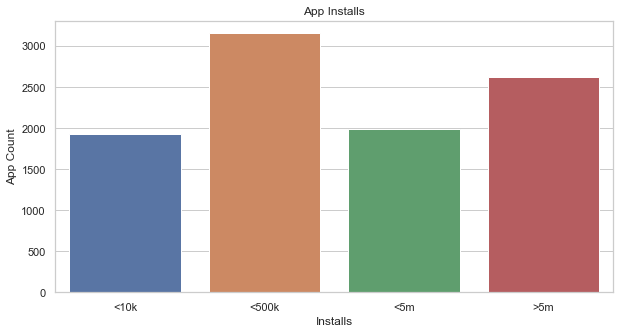

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
sns.set(style="whitegrid")
ax = sns.barplot(df_preprocessed['Installs'].unique(),pd.value_counts(df_preprocessed['Installs']),order=['<10k','<500k','<5m','>5m'])
ax.set(xlabel='Installs',ylabel='App Count',title='App Installs')
plt.savefig('../figures/dfDist.png',dpi=300)
plt.show()

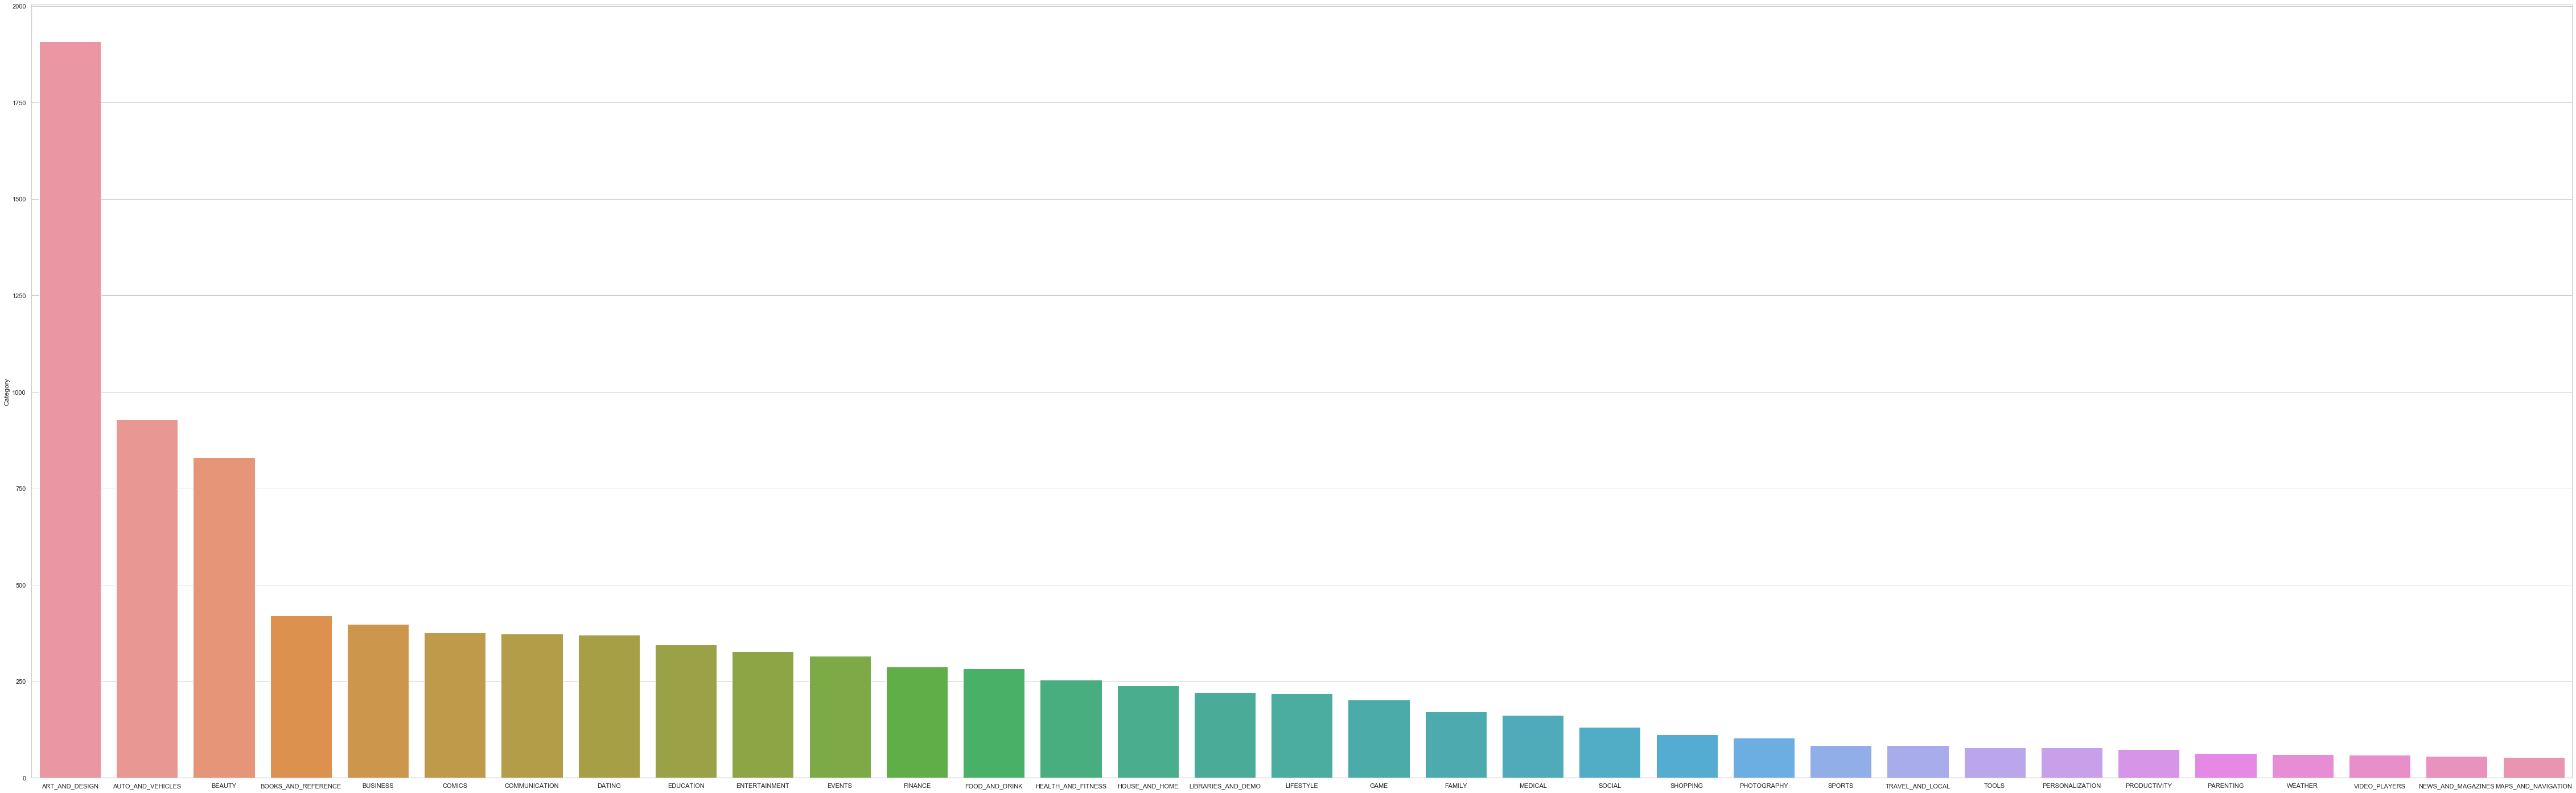

In [29]:
plt.figure(figsize=(80,25))
ax = sns.barplot(df_preprocessed['Category'].unique(),pd.value_counts(df_preprocessed['Category']))
plt.savefig('../figures/dfCategoryDist.png',dpi=300)

In [99]:
cat_frs = ['Category','Type','Content Rating','Action', 'Action & Adventure', 'Adventure', 'Art & Design', 'Arcade',
       'Auto & Vehicles', 'Beauty', 'Board', 'Books & Reference',
       'Brain Games', 'Business', 'Card', 'Casino', 'Casual', 'Comics',
       'Communication', 'Creativity', 'Dating', 'Education', 'Educational',
       'Entertainment', 'Events', 'Finance', 'Food & Drink',
       'Health & Fitness', 'House & Home', 'Libraries & Demo', 'Lifestyle',
       'Maps & Navigation', 'Medical', 'Music', 'Music & Audio',
       'Music & Video', 'News & Magazines', 'Parenting', 'Personalization',
       'Photography', 'Pretend Play', 'Productivity', 'Puzzle', 'Racing',
       'Role Playing', 'Shopping', 'Simulation', 'Social', 'Sports',
       'Strategy', 'Tools', 'Travel & Local', 'Trivia',
       'Video Players & Editors', 'Weather', 'Word', 'Size_varies',
       'Current_Ver_Varies', 'Android_Ver_Varies','Current_Ver_truncated',
       'Android_Ver_truncated']
cont_frs = ['Rating','Reviews','Size','Price','Last Updated']
Free = df_preprocessed[df_preprocessed['Type']=='Free']
Paid = df_preprocessed[df_preprocessed['Type']=='Paid']

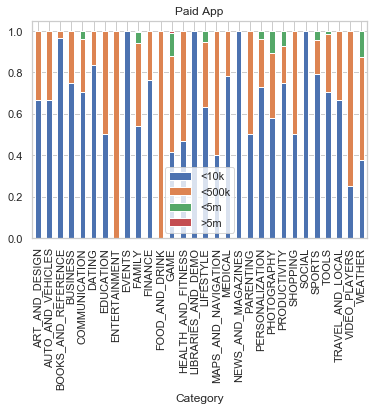

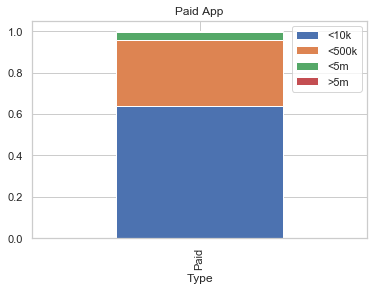

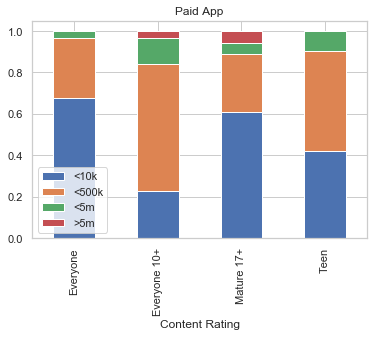

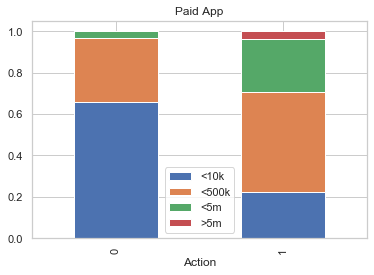

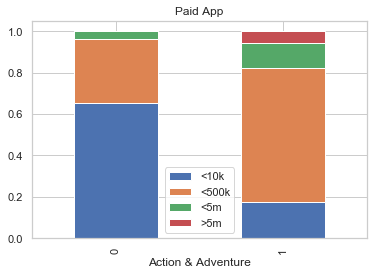

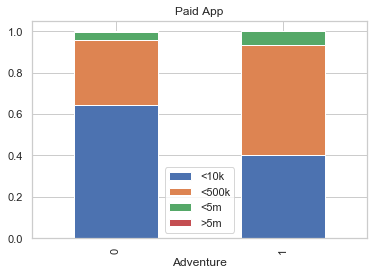

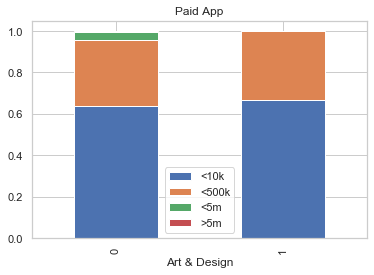

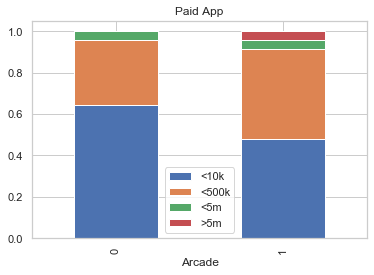

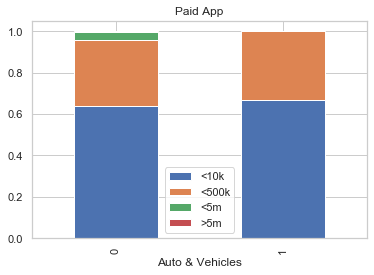

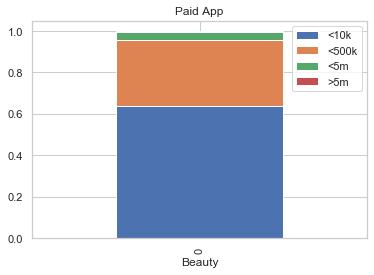

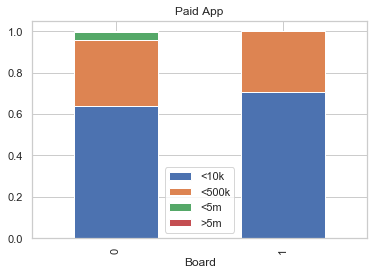

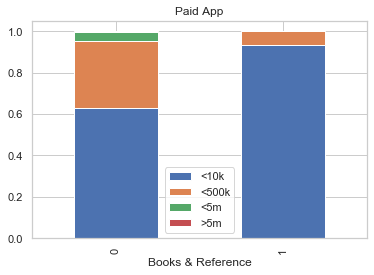

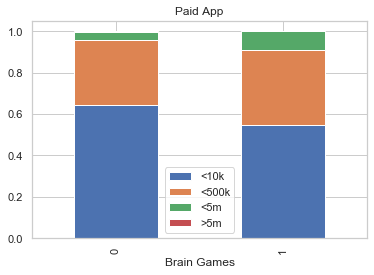

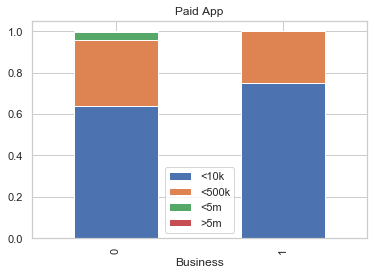

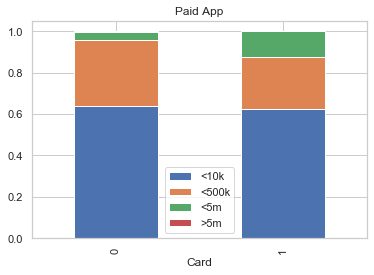

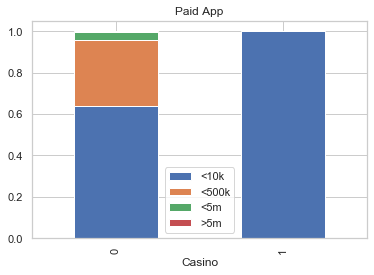

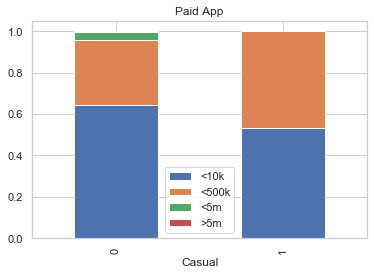

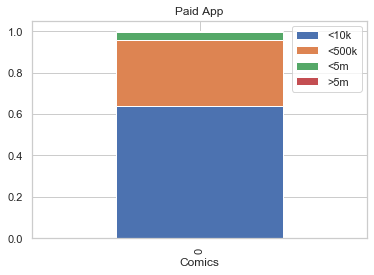

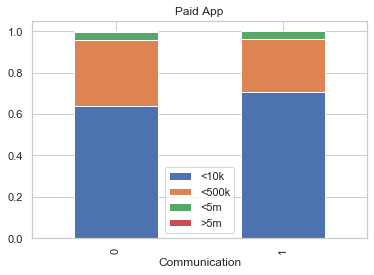

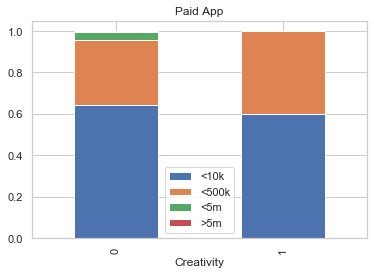

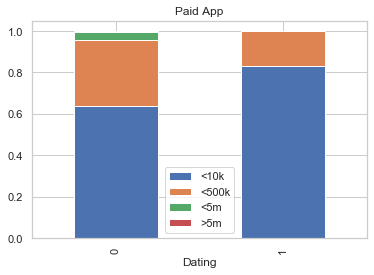

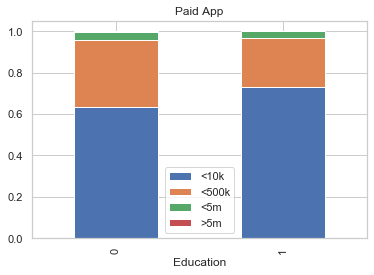

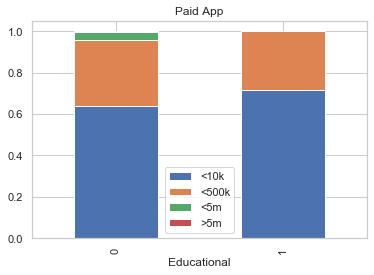

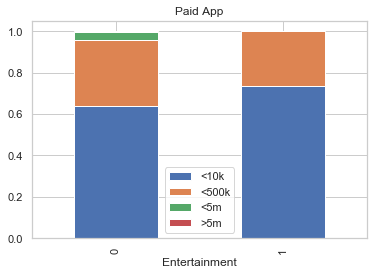

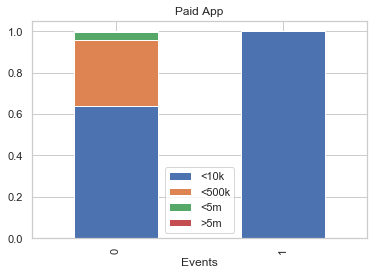

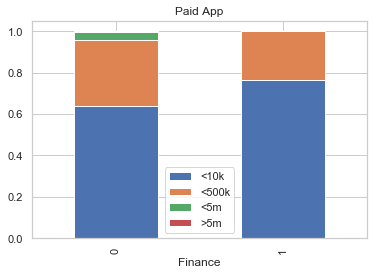

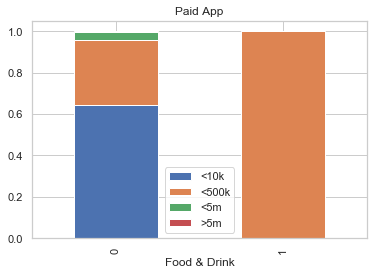

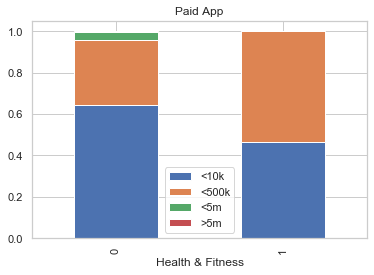

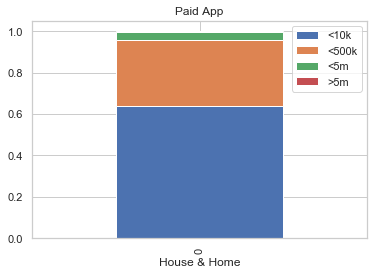

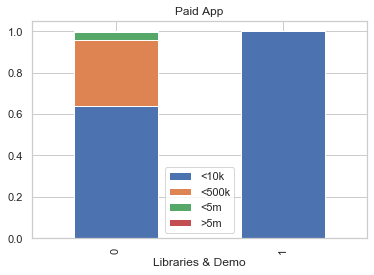

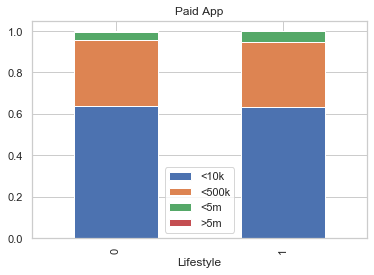

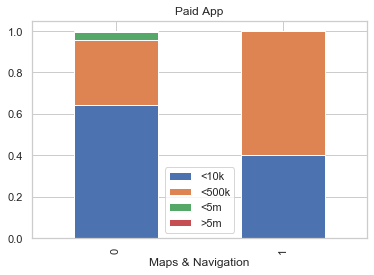

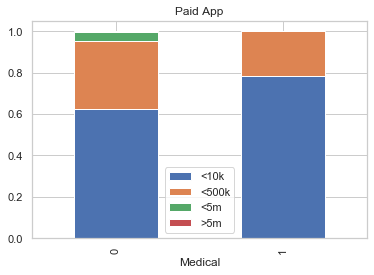

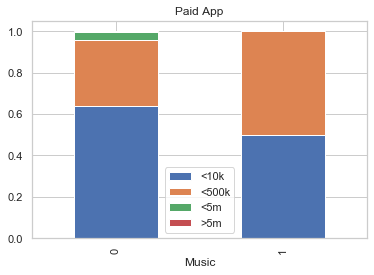

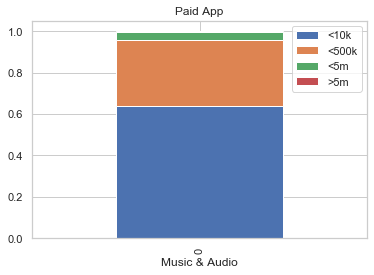

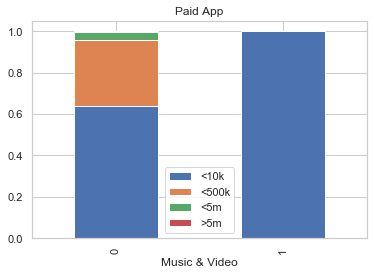

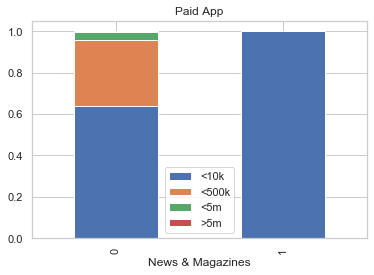

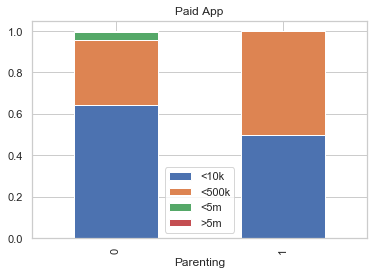

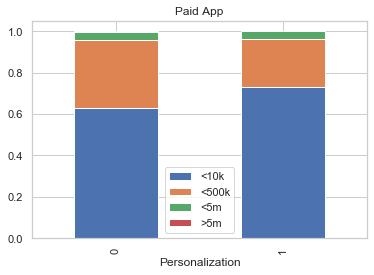

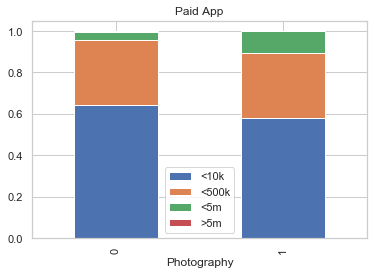

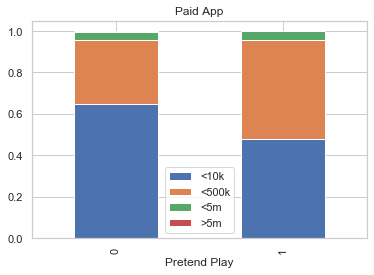

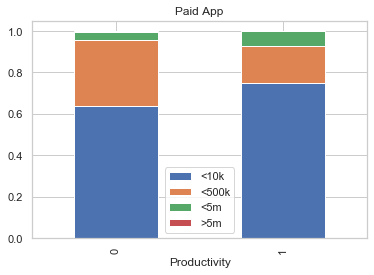

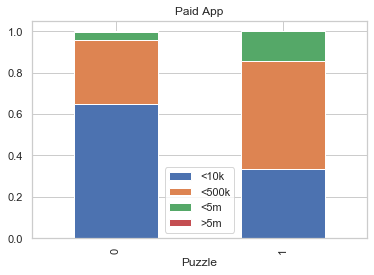

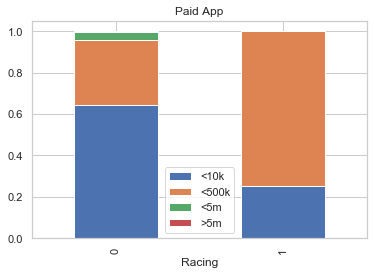

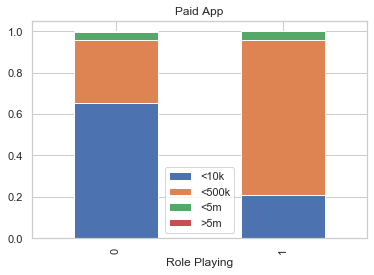

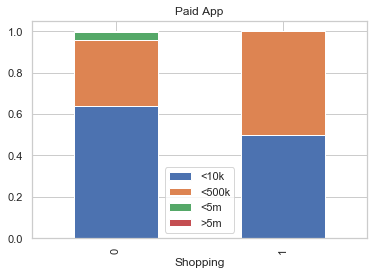

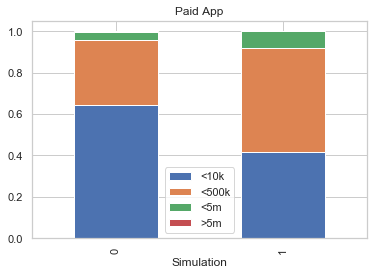

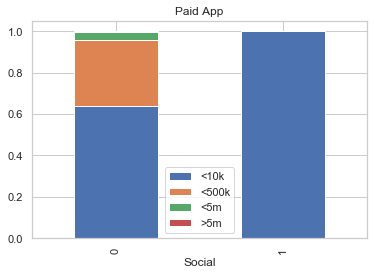

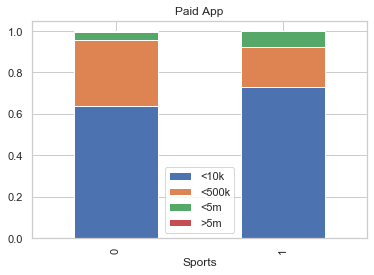

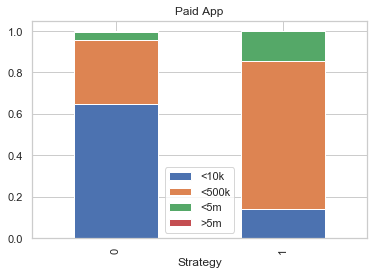

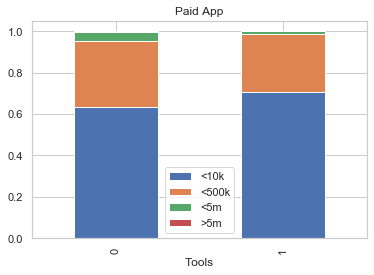

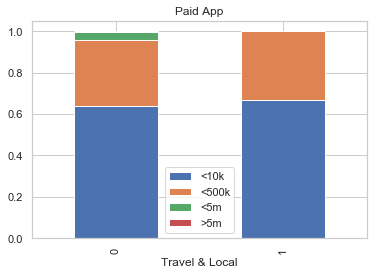

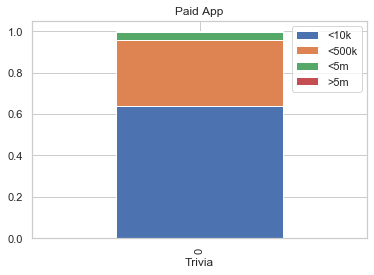

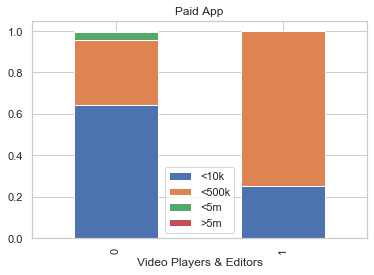

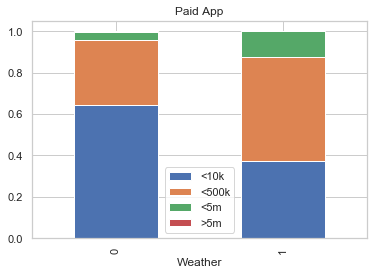

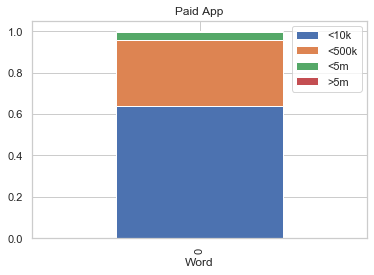

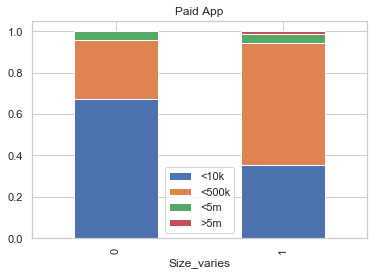

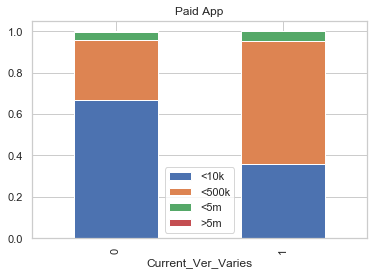

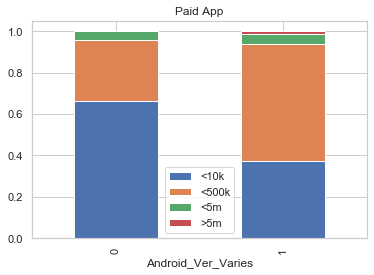

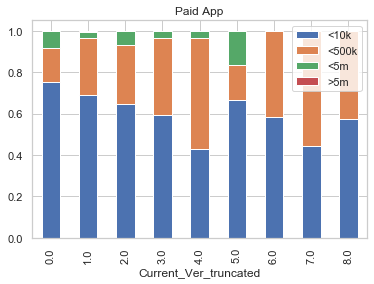

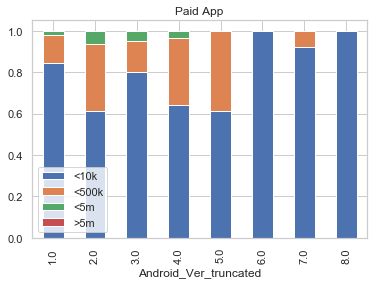

In [91]:
for i in range(len(cat_frs)):
    cat = Paid.groupby([cat_frs[i],'Installs']).size().unstack()
    cat_norm = cat.div(cat.sum(axis=1),axis=0)
    cat_norm.plot(kind='bar', stacked=True)
    plt.xlabel(cat_frs[i])
    plt.legend()
    plt.title('Paid App')
    plt.savefig('../figures/bar%d.png' % i ,dpi=300)
    plt.show()

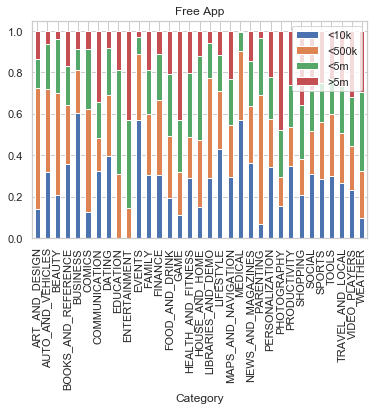

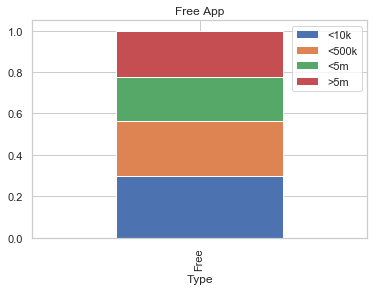

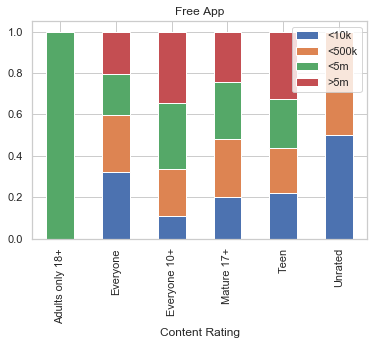

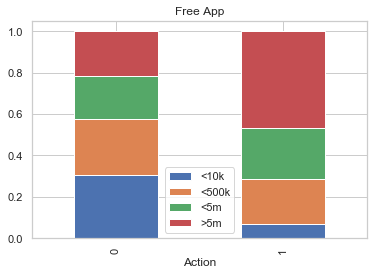

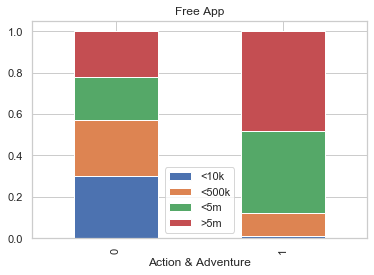

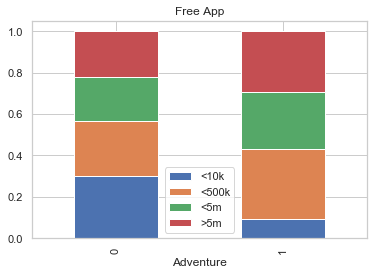

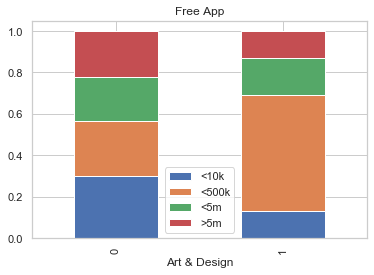

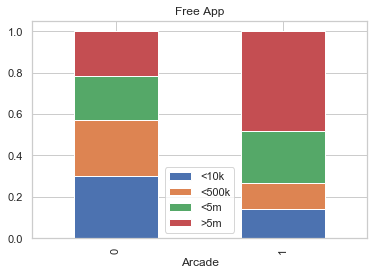

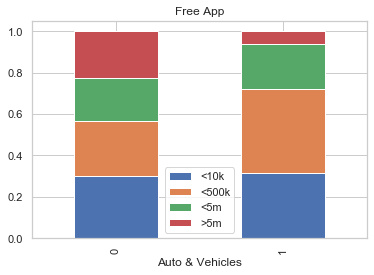

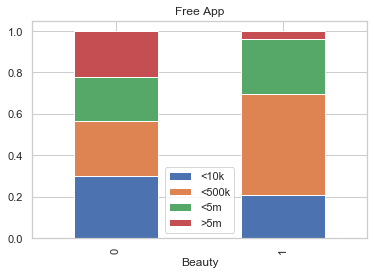

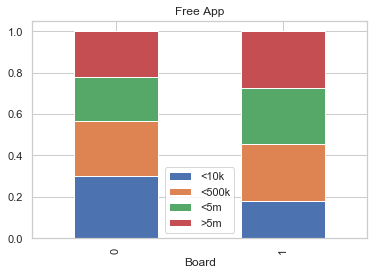

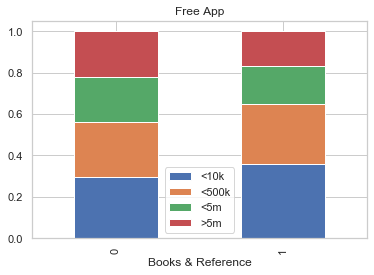

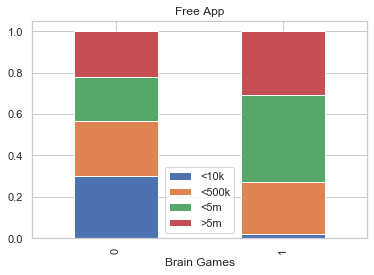

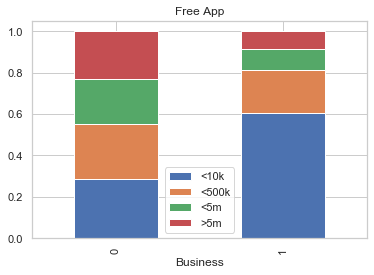

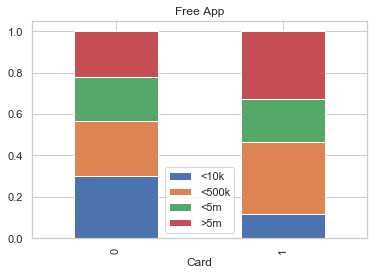

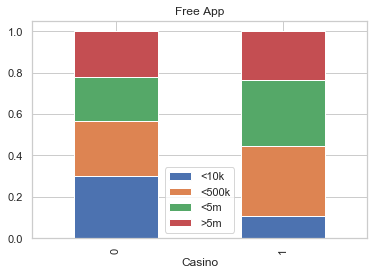

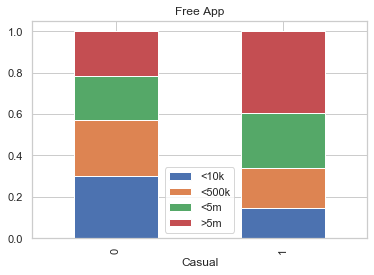

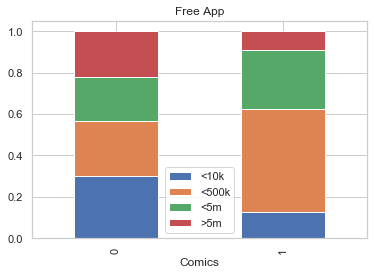

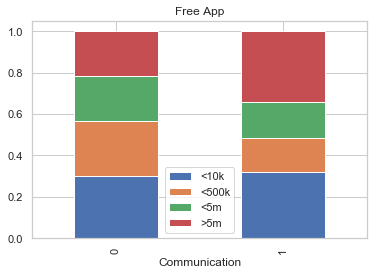

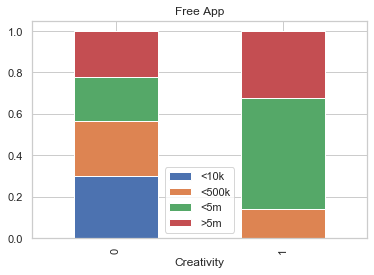

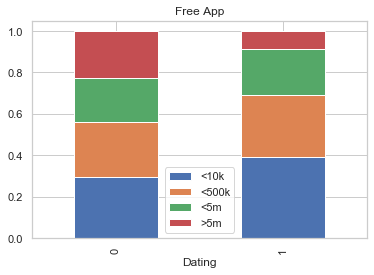

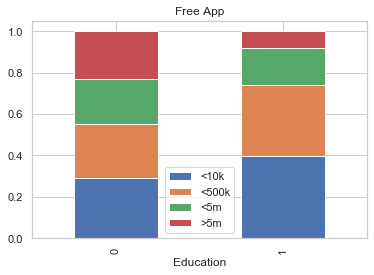

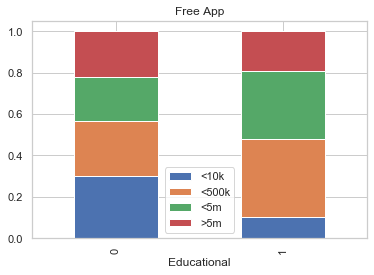

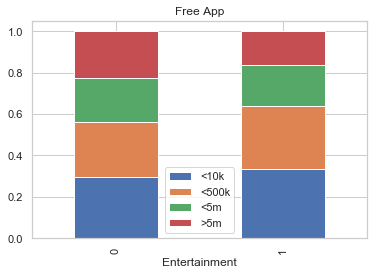

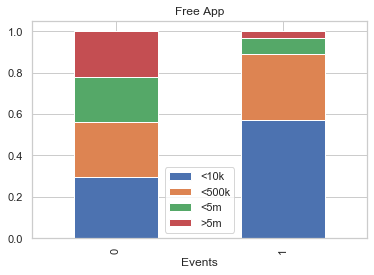

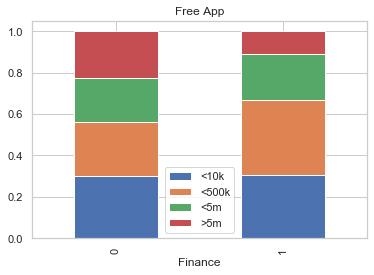

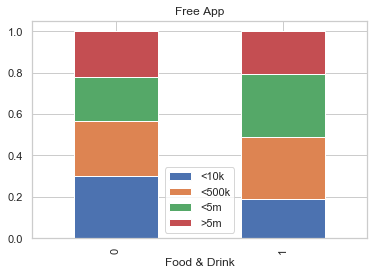

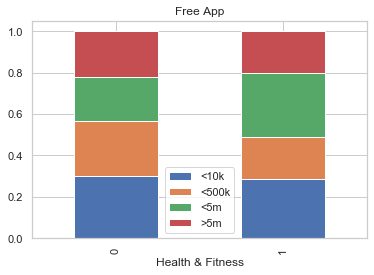

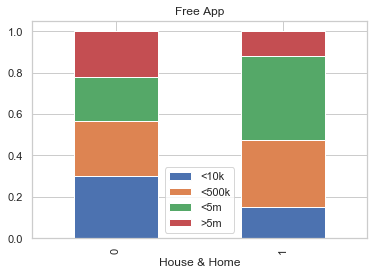

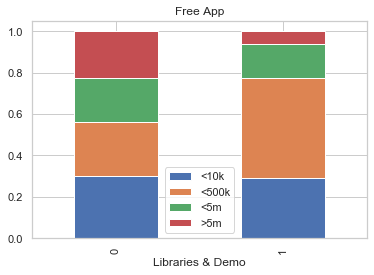

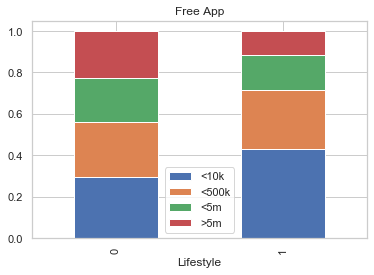

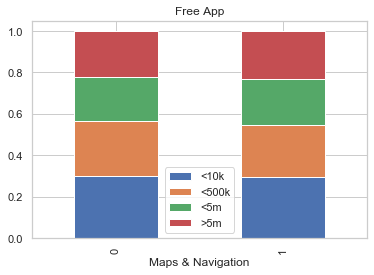

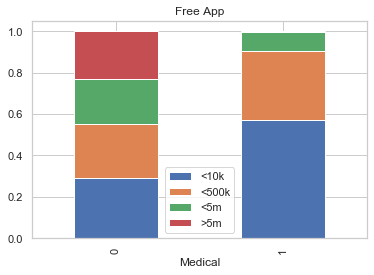

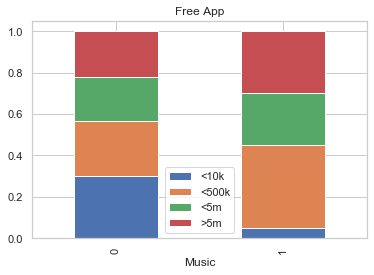

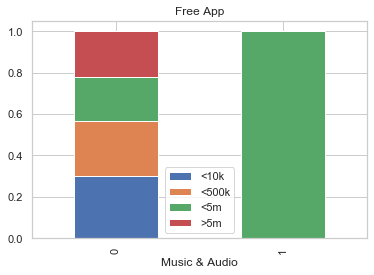

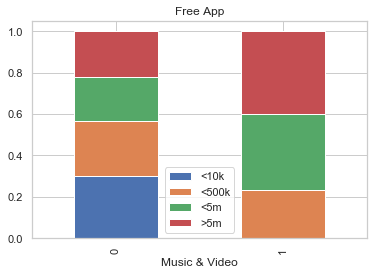

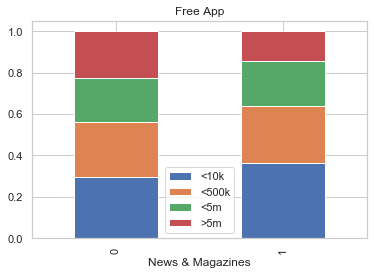

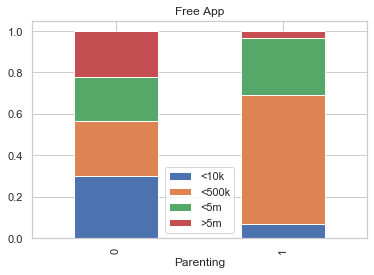

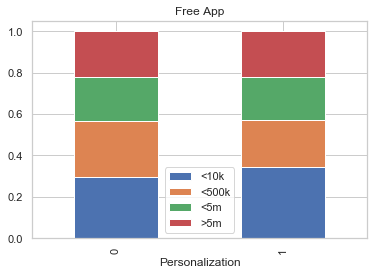

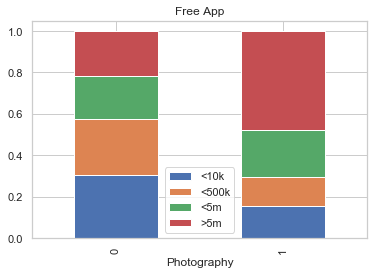

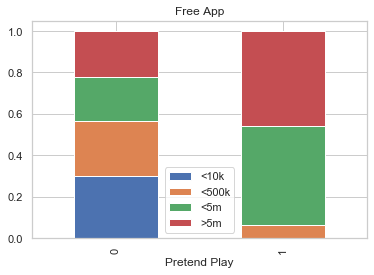

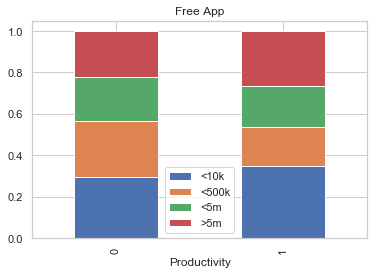

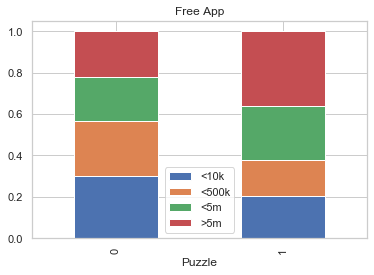

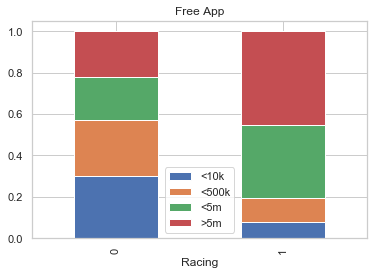

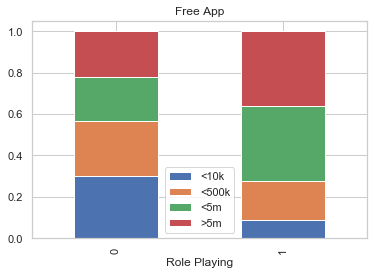

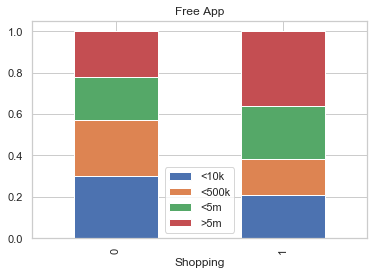

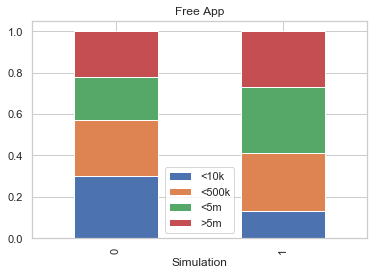

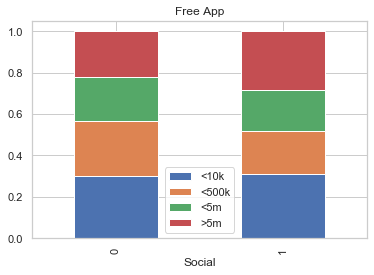

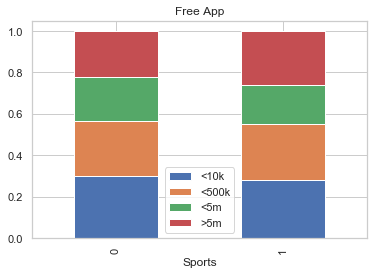

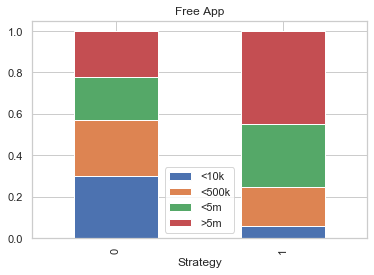

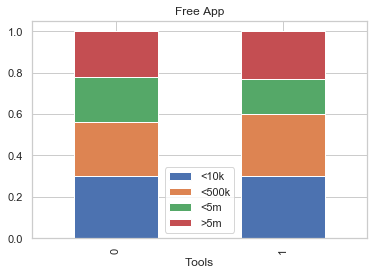

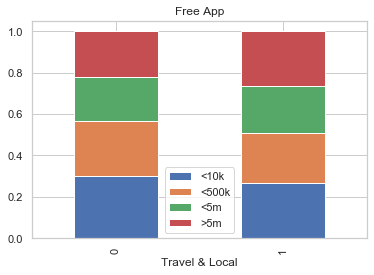

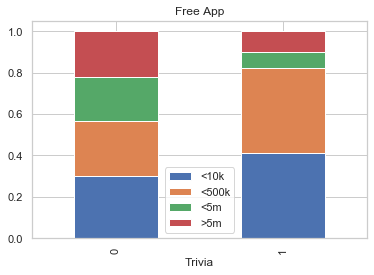

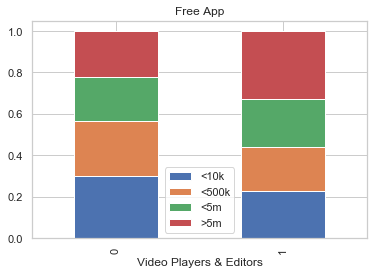

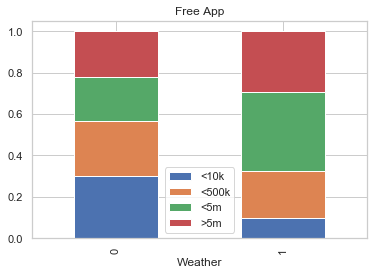

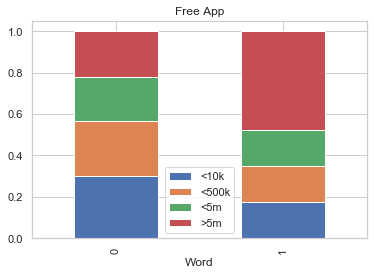

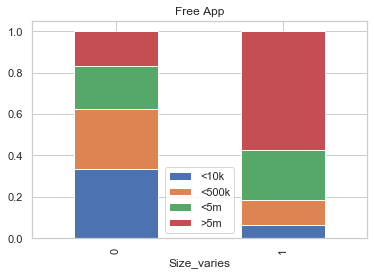

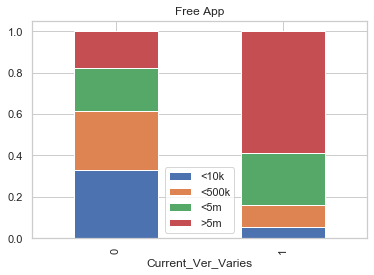

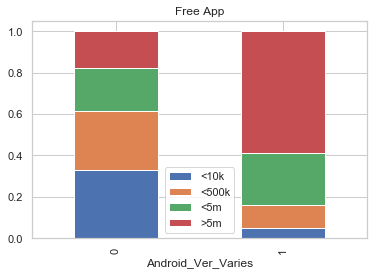

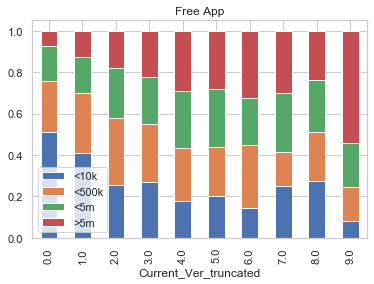

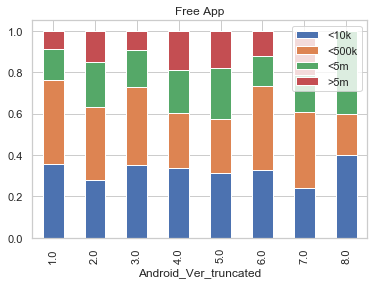

In [90]:
for i in range(len(cat_frs)):
    cat = Free.groupby([cat_frs[i],'Installs']).size().unstack()
    cat_norm = cat.div(cat.sum(axis=1),axis=0)
    cat_norm.plot(kind='bar', stacked=True)
    plt.xlabel(cat_frs[i])
    plt.legend()
    plt.title('Free App')
    plt.savefig('../figures/FreeBar%d.png' % i ,dpi=300)
    plt.show()

In [98]:
train_temp = pd.concat([xTrain,yTrain],axis=1)
train_temp.columns

Index(['App', 'Rating', 'Reviews', 'Size', 'Type', 'Price', 'Content Rating',
       'Last Updated', 'Action', 'Action & Adventure', 'Adventure',
       'Art & Design', 'Arcade', 'Auto & Vehicles', 'Beauty', 'Board',
       'Books & Reference', 'Brain Games', 'Business', 'Card', 'Casino',
       'Casual', 'Comics', 'Communication', 'Creativity', 'Dating',
       'Education', 'Educational', 'Entertainment', 'Events', 'Finance',
       'Food & Drink', 'Health & Fitness', 'House & Home', 'Libraries & Demo',
       'Lifestyle', 'Maps & Navigation', 'Medical', 'Music', 'Music & Audio',
       'Music & Video', 'News & Magazines', 'Parenting', 'Personalization',
       'Photography', 'Pretend Play', 'Productivity', 'Puzzle', 'Racing',
       'Role Playing', 'Shopping', 'Simulation', 'Social', 'Sports',
       'Strategy', 'Tools', 'Travel & Local', 'Trivia',
       'Video Players & Editors', 'Weather', 'Word', 'Size_varies',
       'Current_Ver_Varies', 'Android_Ver_Varies', 'Current_Ver_trunc

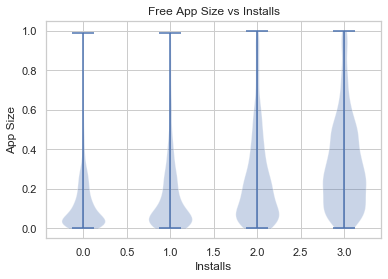

In [92]:
# Prepare violin plot
# for i in range(len(cont_frs)):
#     dataset = [Free[Free['Installs']=='<10k'][cont_frs[i]].values,
#                Free[Free['Installs']=='<500k'][cont_frs[i]].values,
#                Free[Free['Installs']=='<5m'][cont_frs[i]].values,
#                Free[Free['Installs']=='>5m'][cont_frs[i]].values]
#     plt.violinplot(dataset = dataset,positions=['<10k','<500k','<5m','>5m'])
#     plt.xlabel('Installs')
#     plt.ylabel(cont_frs[i])
#     plt.show()

Free_Train = train_temp[train_temp['Type']==0.0]
Paid_Train = train_temp[train_temp['Type']==1.0]
dataset = [Free_Train[Free_Train['Installs']==0.0]['Size'].values,
           Free_Train[Free_Train['Installs']==1.0]['Size'].values,
           Free_Train[Free_Train['Installs']==2.0]['Size'].values,
           Free_Train[Free_Train['Installs']==3.0]['Size'].values]

plt.violinplot(dataset = dataset,positions = [0.0,1.0,2.0,3.0])
plt.xlabel('Installs')
plt.ylabel('App Size')
plt.title('Free App Size vs Installs')
plt.savefig('../figures/FreeAppSize.png',dpi=300)
plt.show()
#dataset

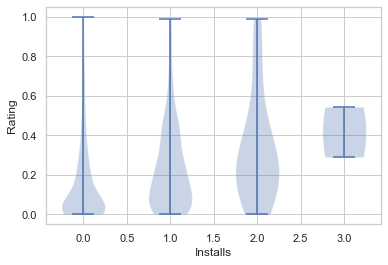

In [59]:
dataset = [Paid_Train[Paid_Train['Installs']==0.0]['Size'].values,
           Paid_Train[Paid_Train['Installs']==1.0]['Size'].values,
           Paid_Train[Paid_Train['Installs']==2.0]['Size'].values,
           Paid_Train[Paid_Train['Installs']==3.0]['Size'].values]
plt.violinplot(dataset = dataset,positions = [0.0,1.0,2.0,3.0])
plt.xlabel('Installs')
plt.ylabel('App Size')
plt.title('Paid App Size vs Installs')
plt.show()

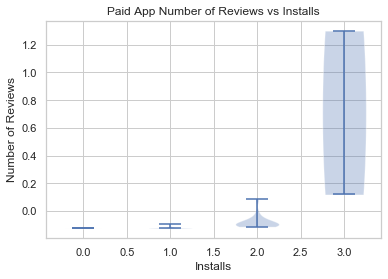

In [93]:
dataset = [Paid_Train[Paid_Train['Installs']==0.0]['Reviews'].values,
           Paid_Train[Paid_Train['Installs']==1.0]['Reviews'].values,
           Paid_Train[Paid_Train['Installs']==2.0]['Reviews'].values,
           Paid_Train[Paid_Train['Installs']==3.0]['Reviews'].values]
plt.violinplot(dataset = dataset,positions = [0.0,1.0,2.0,3.0])
plt.xlabel('Installs')
plt.ylabel('Number of Reviews')
plt.title('Paid App Number of Reviews vs Installs')
plt.savefig('../figures/PaidAppReviews.png',dpi=300)
plt.show()

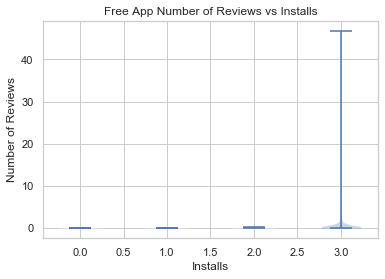

In [96]:
dataset = [Free_Train[Free_Train['Installs']==0.0]['Reviews'].values,
           Free_Train[Free_Train['Installs']==1.0]['Reviews'].values,
           Free_Train[Free_Train['Installs']==2.0]['Reviews'].values,
           Free_Train[Free_Train['Installs']==3.0]['Reviews'].values]
plt.violinplot(dataset = dataset,positions = [0.0,1.0,2.0,3.0])
plt.xlabel('Installs')
plt.ylabel('Number of Reviews')
plt.title('Free App Number of Reviews vs Installs')
plt.savefig('../figures/FreeAppReviews.png',dpi=300)
plt.title('Free App Number of Reviews vs Installs')
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


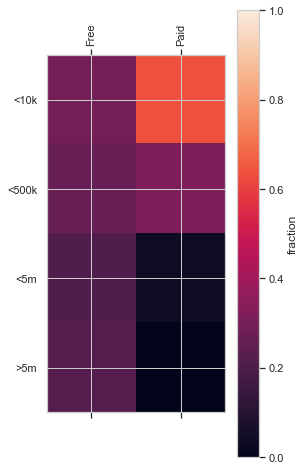

In [88]:
count_matrix = df_preprocessed.groupby(['Type', 'Installs']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
#print(count_matrix_norm)
plt.matshow(count_matrix_norm.T,vmin=0,vmax=1)
plt.xticks(np.arange(count_matrix_norm.shape[0]),count_matrix_norm.index,rotation=90)
plt.yticks(np.arange(count_matrix_norm.shape[1]),count_matrix_norm.columns)
plt.colorbar(label='fraction')
plt.tight_layout()
plt.savefig('../figures/matTypeInstall.png',dpi=350)
plt.show()

In [83]:
df_preprocessed

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Last Updated,...,Travel & Local,Trivia,Video Players & Editors,Weather,Word,Size_varies,Current_Ver_Varies,Android_Ver_Varies,Current_Ver_truncated,Android_Ver_truncated
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.000,<500k,Free,0.0,Everyone,2018-01-07,...,0,0,0,0,0,0,0,0,1.0,4.0
1,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.000,>5m,Free,0.0,Everyone,2018-08-01,...,0,0,0,0,0,0,0,0,1.0,4.0
2,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.000,>5m,Free,0.0,Teen,2018-06-08,...,0,0,0,0,0,0,1,0,NaN,4.0
3,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.000,<500k,Free,0.0,Everyone,2018-06-20,...,0,0,0,0,0,0,0,0,1.0,4.0
4,Paper flowers instructions,ART_AND_DESIGN,4.4,167,5.000,<500k,Free,0.0,Everyone,2017-03-26,...,0,0,0,0,0,0,0,0,1.0,2.0
5,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,3.8,178,19.000,<500k,Free,0.0,Everyone,2018-04-26,...,0,0,0,0,0,0,0,0,1.0,4.0
6,Infinite Painter,ART_AND_DESIGN,4.1,36815,29.000,<5m,Free,0.0,Everyone,2018-06-14,...,0,0,0,0,0,0,0,0,6.0,4.0
7,Garden Coloring Book,ART_AND_DESIGN,4.4,13791,33.000,<5m,Free,0.0,Everyone,2017-09-20,...,0,0,0,0,0,0,0,0,2.0,3.0
8,Kids Paint Free - Drawing Fun,ART_AND_DESIGN,4.7,121,3.000,<500k,Free,0.0,Everyone,2018-07-03,...,0,0,0,0,0,0,0,0,2.0,4.0
9,Text on Photo - Fonteee,ART_AND_DESIGN,4.4,13880,28.000,<5m,Free,0.0,Everyone,2017-10-27,...,0,0,0,0,0,0,0,0,1.0,4.0


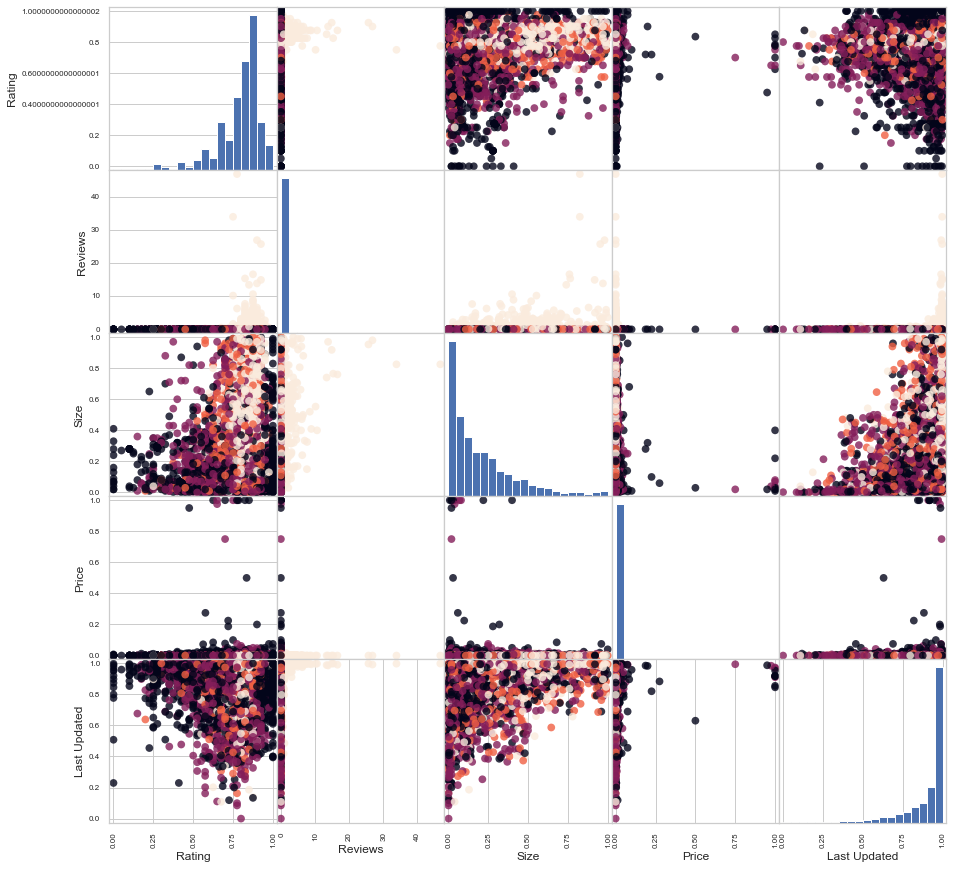

In [102]:
pd.plotting.scatter_matrix(train_temp[cont_frs],c = train_temp['Installs'], figsize=(15, 15), marker='o',
                           hist_kwds={'bins': 20}, s=60, alpha=.8)
plt.savefig('../figures/scatter_matrix_conts.png',dpi=350)
#plt.savefig('figures/scatter_matrix_conts.png',dpi=300)
plt.show()